# Example Script for comparing different priorization algorithms

In [1]:
# some imports
from utils import get_metadata_for_images_in_folder
from pathlib import Path
from image_priorization.structures import ImageCorners, Polygon
from image_priorization.geometric_utils import calculate_polygon_area_on_sphere
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.validation import make_valid
from image_priorization.lp_optimization import filter_images_lp_optimization
from image_priorization.greedy_priorization import filter_images_greedy_algorithm
from image_priorization.structures import ImageWithDetections, PointRest, convert_shapely_to_polygon, convert_polygon_to_shapely
from image_priorization.greedy_priorization import convert_images_to_pandas


## Load all the metadata

In [2]:
image_folder = "/home/const/Development/SearchWing/searchwing-gui/backend/data/2022-07-08T09-29-49-maggy"
metadata, images_with_detections = get_metadata_for_images_in_folder(Path(image_folder))
metadata

{'2022-07-08T09-37-56.174220': {'ExifOffset': 61,
  'Artist': 'maggy-caml',
  'GPSInfo': 479,
  'SubsecTimeOriginal': '174220',
  'DateTimeOriginal': '2022:07:08 09:37:56',
  'UserComment': b'ASCII\x00\x00\x00{"imgcrns": {"ul": "48.42613220214844,11.210089683532715,0.0", "ur": "48.4254264831543,11.208524703979492,0.0", "lr": "48.42628479003906,11.207913398742676,0.0", "ll": "48.42681121826172,11.209352493286133,0.0"}, "imgcrnsGSD": {"ul": "0.043068476021289825", "ur": "0.049597226083278656", "lr": "0.0369938388466835", "ll": "0.03321436047554016"}}',
  'UserCommentSimplified': {'imgcrns': {'ul': [48.42613220214844,
     11.210089683532715,
     0.0],
    'ur': [48.4254264831543, 11.208524703979492, 0.0],
    'lr': [48.42628479003906, 11.207913398742676, 0.0],
    'll': [48.42681121826172, 11.209352493286133, 0.0]},
   'imgcrnsGSD': {'ul': '0.043068476021289825',
    'ur': '0.049597226083278656',
    'lr': '0.0369938388466835',
    'll': '0.03321436047554016'}},
  'ImageCrns': ImageCorn

In [3]:
## collect entire area
meta_valid = convert_images_to_pandas(images_with_detections)
meta_valid["camera"] = [metadata[i]["Artist"] for i in meta_valid.index]

# we filter areas with no valid polygons (e.g. if two points collapse)
meta_valid["polygon"] = meta_valid.apply( lambda row: make_valid(row["polygon"]), axis=1)
meta_valid = meta_valid [meta_valid.apply( lambda row: isinstance(row["polygon"], Polygon), axis=1)]

# filter based on area 
meta_valid["area"] = meta_valid.apply(lambda row: calculate_polygon_area_on_sphere(row["polygon"]), axis=1)
meta_valid = meta_valid[meta_valid["area"] < (meta_valid["area"].mean() + 1 * meta_valid["area"].std())]
print(f"Collected: {len(metadata)} images. {len(meta_valid)} are valid!")


Collected: 646 images. 527 are valid!


/home/const/Development/venvs/image_filter/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/home/const/Development/venvs/image_filter/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Analyse Input data

In [4]:
 p = gpd.GeoSeries(unary_union(meta_valid["polygon"]))
 #p.plot()
 [i for i in meta_valid["polygon"].iloc[0].exterior.coords]

[(48.42613220214844, 11.210089683532715),
 (48.4254264831543, 11.208524703979492),
 (48.42628479003906, 11.207913398742676),
 (48.42681121826172, 11.209352493286133),
 (48.42613220214844, 11.210089683532715)]

In [5]:
## just see whether we have large outliers
lat = []
lon = []
for _, row in meta_valid.iterrows():
    lat.extend([i[0] for i in row["polygon"].exterior.coords])
    lon.extend([i[1] for i in row["polygon"].exterior.coords])

Text(0.5, 0, 'lon')

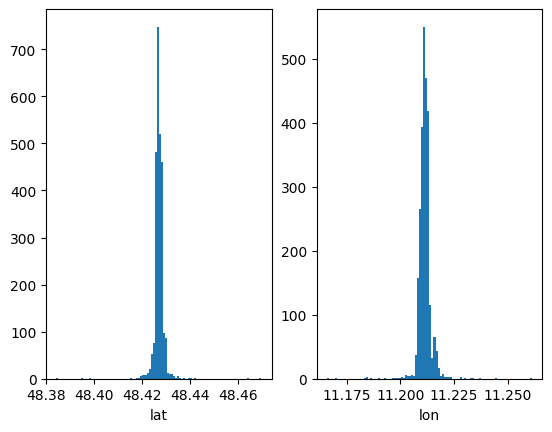

In [6]:
_, axes = plt.subplots(1, 2)
axes[0].hist(lat, bins=100)
axes[0].set_xlabel("lat")
axes[1].hist(lon, bins=100)
axes[1].set_xlabel("lon")

Maximum 3877713.804640875   Median: 29409.292040107306 


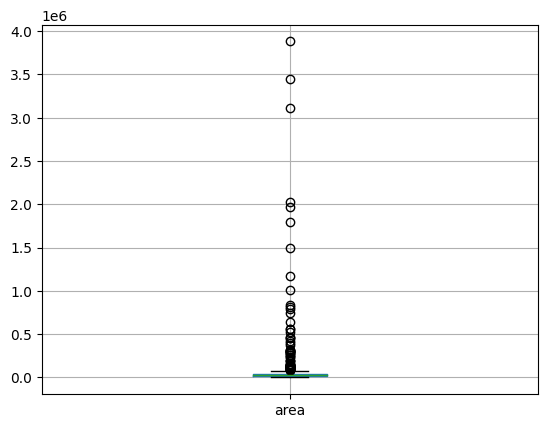

In [7]:
meta_valid.boxplot(column=["area"])
print(f"Maximum {meta_valid['area'].max()}   Median: {meta_valid['area'].median()} ")

## Filter every n seconds

In [8]:
#simple n seconds implementation
n_seconds = 3
selected_indices = []
for (camera, camera_meta) in meta_valid.groupby(by="camera"):
    print(f"Process Camera: {camera}")
    flight_start = camera_meta["datetime_original"].min()
    flight_end = camera_meta["datetime_original"].max()
    camera_meta = meta_valid.sort_values(by="datetime_original")
    camera_meta["time_diff"] = camera_meta.apply(lambda row: row["datetime_original"] - flight_start, axis=1)
    n_seconds_series = pd.Series([pd.Timedelta(seconds=i) for i in range(0, int((flight_end - flight_start).seconds), n_seconds)])
    selected_indices.extend(camera_meta.apply(lambda row: abs(n_seconds_series - row["time_diff"]), axis=1).idxmin(axis=0).to_list())



Process Camera: maggy-caml
Process Camera: maggy-camr


In [9]:
filtered_n_seconds = meta_valid.loc[selected_indices]
area_n_seconds = calculate_polygon_area_on_sphere(unary_union(filtered_n_seconds['polygon']))
total_covered_area = calculate_polygon_area_on_sphere(unary_union(meta_valid['polygon']))
print(f"Total images kepts: {len(filtered_n_seconds)}  Covered area: {area_n_seconds}. Percentage of total area: {area_n_seconds/total_covered_area * 100}")


Total images kepts: 427  Covered area: 11625001.827707458. Percentage of total area: 85.20853983501675


<AxesSubplot: >

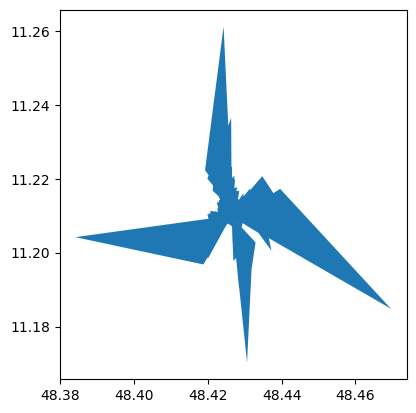

In [10]:
p = gpd.GeoSeries(unary_union(filtered_n_seconds['polygon']))
p.plot()

## Filter Greedy Algorithms

In [11]:
# Sort images by increasing timestamp
# Take first image area and set as last image to keep
# Take next image area after last image and calc overlap with last image
# if overlap < treshold (e.g. 10%) or detection_prob > treshold: set as last image to keep
# Jump to step 2


area_thresh_max = 0.05
force_overlap = True


images_selected_greedy = []
for (camera, camera_meta) in meta_valid.groupby(by="camera"):
    print(f"Process {camera} with size: {len(camera_meta)}")
    # convert images to Detections
    image_input = {k: images_with_detections[k] for k in camera_meta.index}
    images_selected_greedy.extend(filter_images_greedy_algorithm(image_input, area_thresh_max=area_thresh_max, force_overlap=force_overlap))
    

Process maggy-caml with size: 314
Process maggy-camr with size: 213


Total images kepts: 232  Covered area: 12895255.076472966. Percentage of total area: 94.51919854734663


<AxesSubplot: >

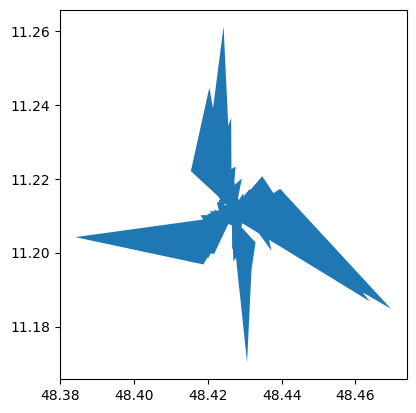

In [12]:
filtered_greedy = meta_valid.loc[images_selected_greedy]
area_greedy= calculate_polygon_area_on_sphere(unary_union(filtered_greedy['polygon']))
total_covered_area = calculate_polygon_area_on_sphere(unary_union(meta_valid['polygon']))
print(f"Total images kepts: {len(filtered_greedy)}  Covered area: {area_greedy}. Percentage of total area: {area_greedy/total_covered_area * 100}")
p = gpd.GeoSeries(unary_union(filtered_greedy['polygon']))
p.plot()

## Filter LP Algorithm

In [13]:
# ToDo: LP Algorithm is for a real use-case too slow
image_input = {}
image_return = {}
max_num = 50
image_input = {k: images_with_detections[k] for i, k in enumerate(camera_meta.index) if i < max_num}
out = filter_images_lp_optimization(images=image_input, num_images=10, keep_keys=[])

/home/const/Development/venvs/image_filter/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/const/Development/venvs/image_filter/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/2b50c277ac8943bfbbe8af71b732700a-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/2b50c277ac8943bfbbe8af71b732700a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 422 COLUMNS
At line 2495 RHS
At line 2913 BOUNDS
At line 3172 ENDATA
Problem MODEL has 417 rows, 258 columns and 1298 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.99397e+06 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 216 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 14 strengthened rows, 0 substitutions
Cgl

In [14]:
# store image detections for usage e.g. in tests
import json
with open("images_with_detection.json", "w") as fio:
    json.dump([json.loads(images_with_detections[k].json()) for k in camera_meta.index], fio)

In [78]:
len(camera_meta)

213

In [15]:
metadata

{'2022-07-08T09-37-56.174220': {'ExifOffset': 61,
  'Artist': 'maggy-caml',
  'GPSInfo': 479,
  'SubsecTimeOriginal': '174220',
  'DateTimeOriginal': '2022:07:08 09:37:56',
  'UserComment': b'ASCII\x00\x00\x00{"imgcrns": {"ul": "48.42613220214844,11.210089683532715,0.0", "ur": "48.4254264831543,11.208524703979492,0.0", "lr": "48.42628479003906,11.207913398742676,0.0", "ll": "48.42681121826172,11.209352493286133,0.0"}, "imgcrnsGSD": {"ul": "0.043068476021289825", "ur": "0.049597226083278656", "lr": "0.0369938388466835", "ll": "0.03321436047554016"}}',
  'UserCommentSimplified': {'imgcrns': {'ul': [48.42613220214844,
     11.210089683532715,
     0.0],
    'ur': [48.4254264831543, 11.208524703979492, 0.0],
    'lr': [48.42628479003906, 11.207913398742676, 0.0],
    'll': [48.42681121826172, 11.209352493286133, 0.0]},
   'imgcrnsGSD': {'ul': '0.043068476021289825',
    'ur': '0.049597226083278656',
    'lr': '0.0369938388466835',
    'll': '0.03321436047554016'}},
  'ImageCrns': ImageCorn